## Load the data
* Exract `Abstract` and `Titles`

In [ ]:
# Load data from Hugging Face
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]
# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

# Steps for text clustering

1. Convert the input documents to embeddings with an embedding
model.
2. Reduce the dimensionality of embeddings with a dimensionality
reduction model.
3. Find groups of semantically similar documents with a cluster
model.

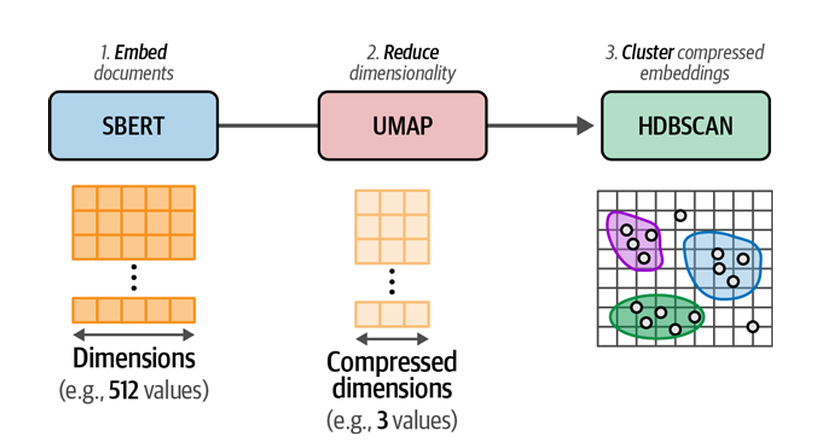


## Step 1. Convert input into Embeddings

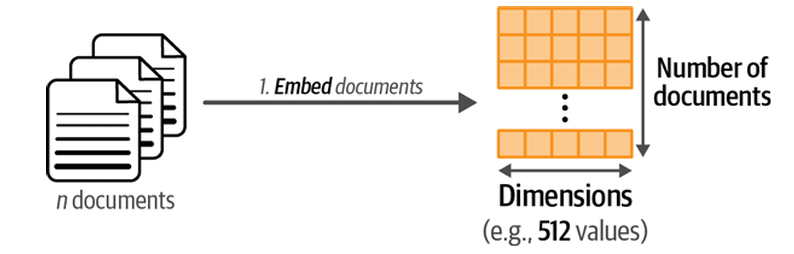

In [ ]:
from sentence_transformers import SentenceTransformer
# Create an embedding for each abstract
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(abstracts,
show_progress_bar=
True
)


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [ ]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(44949, 384)

## step 2. Redusing the Dimensionality using `Uniform Manifold Approximation and Projection (UMAP)`.

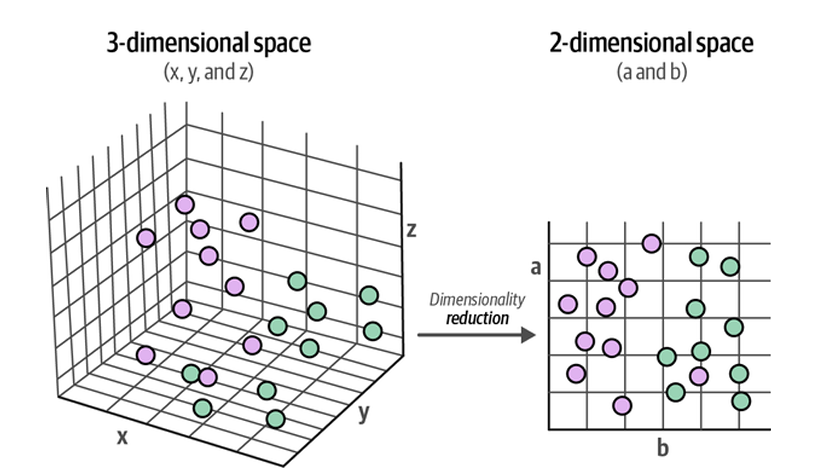

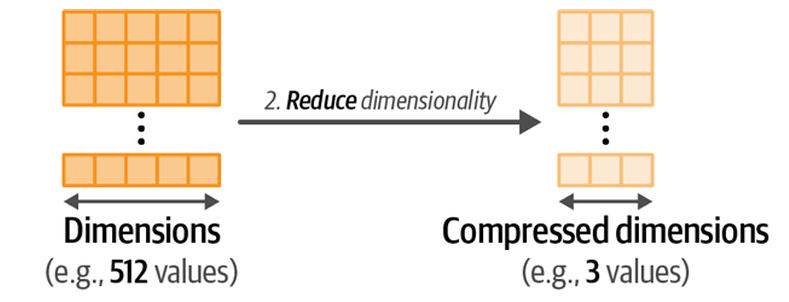

In [ ]:
from umap import UMAP
# We reduce the input embeddings from 384 dimensions to 5 dimensions
umap_model = UMAP(
      n_components=5,  # decide the shape of the lower-dimensional space (Generally, values between5 and 10 work well to capture high-dimensional global structures.)
      min_dist=0.0,    #  minimum distance between embedded points.  We are setting this to 0 as that generally results in tighter clusters.
      metric='cosine',
      random_state=42
  )
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
reduced_embeddings.shape

(44949, 5)

## Step 3. Clustering the reduced embeddings

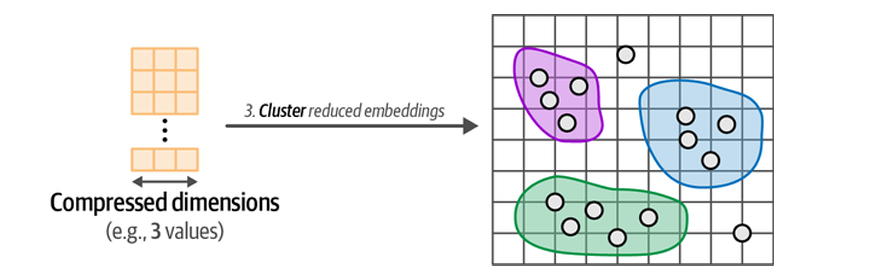

In [ ]:
from hdbscan import HDBSCAN
# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50,
    metric="euclidean",
    cluster_selection_method="eom"
).fit(reduced_embeddings)

clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


155

## Inspecting the Clusters

In [ ]:
import numpy as np
# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
  print(abstracts[int(index)][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



## To visualize the clusters we need 2 dimensional embeddings

In [ ]:
import pandas as pd
# Reduce 384-dimensional embeddings to two dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2,
    min_dist=0.0,
    metric="cosine",
    random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
to_plot = df.loc[df.cluster != "-1", :]
outliers = df.loc[df.cluster == "-1", :]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(np.float64(-7.282655382156372),
 np.float64(11.277046823501587),
 np.float64(-6.28760678768158),
 np.float64(10.93724067211151))

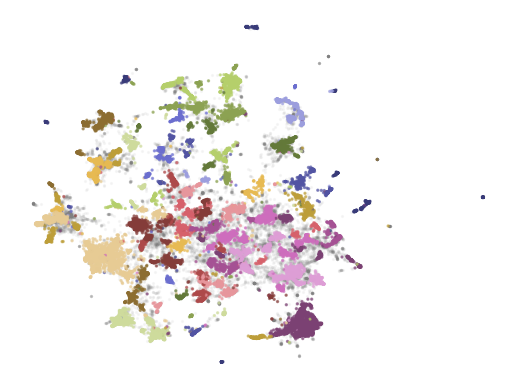

In [ ]:
import matplotlib.pyplot as plt
# Plot outliers and non-outliers separately
plt.scatter(outliers.x, outliers.y, alpha=0.05, s=2, c="grey")

plt.scatter(
  to_plot.x,
  to_plot.y,
  c=to_plot.cluster.astype(int),
  alpha=0.6,
  s=2,
  cmap="tab20b"
)

plt.axis("off")

# Text Clustering to Topic Modeling